In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline
from datetime import datetime, date, timedelta
import calendar
sns.set_style("whitegrid")
sns.set_context("poster")

In [ ]:
logins = 'logins.json'

logins_df = pd.read_json(logins)
logins_df.head()


In [89]:
logins_df.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


## Part 1

We were asked to do exploratory analysis of data containing user logins in a particular geographic location and group them based on 15-minute intervals and count them.  Python's grouper function was used to aggregate the data into 15 minute intervals, then for visualization purposes, those data were split into separate dataframes by day and put in order in a list.  In order to visualize them, we overlayed line plots on the same plot if they are from the same weekday/weekend and observed for trends.

From the below plots, we can make a couple of observations:<br>
1. Weekend traffic is much higher between midnight and 5am, and traffic stays low for the rest of the day <br>
2. On weekday's, traffic starts around 630AM and settles down around 1PM, then picks up again around 7PM and keeps the high volume until the next day, dropping slowly until 5AM.
3. There are definite outliers (Red plot on Saturday, Blue plot on Tuesday) which is most likely to be from bad data.

In [90]:
def plot_weekly_plot(day, daily_list):
    '''
    plots by getting data for that given day over weeks
    0 -> Thursday (since 1970/1/1 is a thurday)
    1 -> Friday
    ...
    6 -> Wednesday
    '''
    num_to_day = {0:'Thursday', 1:'Friday', 2:'Saturday', 3:'Sunday',
                  4:'Monday', 5:'Tuesday', 6:'Wednesday'}
    for i in range(day, len(daily_list), 7):
        #strip date from timestamp
        df = daily_list[i]
        date = df.index[0].to_pydatetime()
        date = str(date.year)+'/'+str(date.month)+'/'+str(date.day)
        ser = pd.to_datetime(df.index).to_series()
        df = df.set_index(ser.dt.time)
        if i < 7:
            ax = df.plot(legend=False, rot=45)
        else:
            df.plot(ax=ax, legend=False, rot=45)
    ax.set_title(num_to_day[day])
    ax.set_ylabel('count')
    

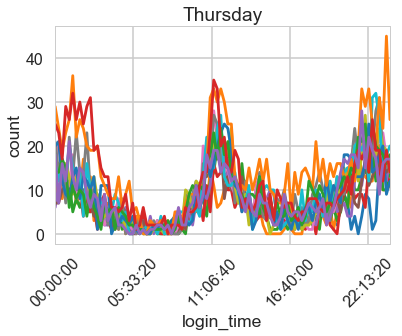

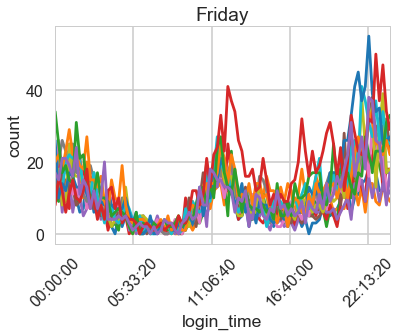

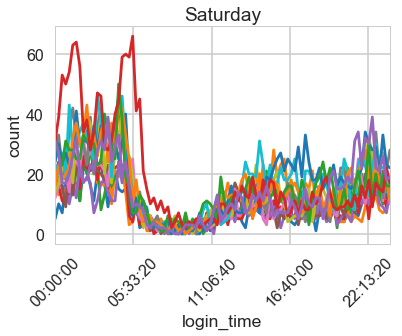

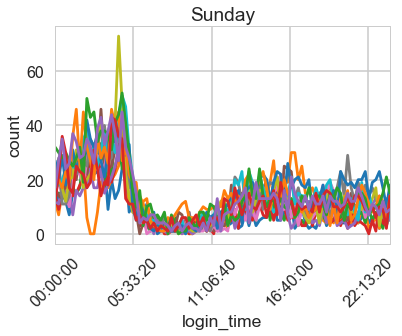

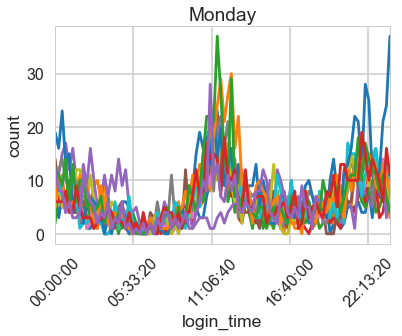

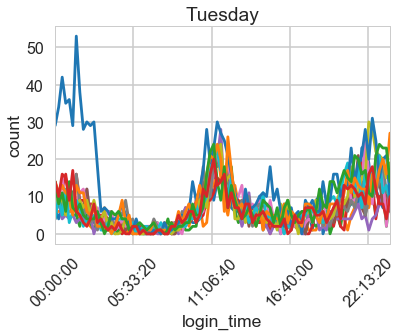

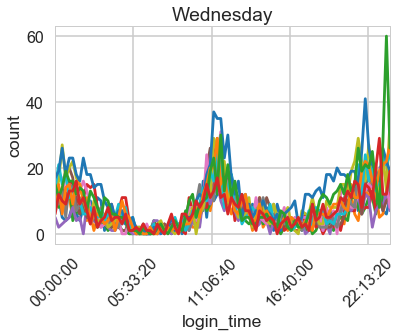

In [91]:
##aggregate by 15 mins
agg_15m = logins_df.reset_index().set_index('login_time')\
            .groupby(pd.TimeGrouper(freq='15Min')).count()

#for easier visualization, plot by week

daily_list = []
for group in agg_15m.groupby(pd.Grouper(freq='D')):
    daily_list.append(group[1])

for i in range(7):
    plot_weekly_plot(i, daily_list)



## Part 2

1. The key measure for this experiment needs to be a metric representing how much commuters came from one city to the other.  Since the current situation of having a two-way toll keeps the drivers exclusive to their own cities, a metric we can use to measure success is how much toll was paid daily.  A good resaon for choosing this metric is that it directly correlates to the number of cars passing through the bridge which explains activity amongst the two cities.  <br>


2. Before we implement the experiement, we must collect data on a normal week.  We would need daily data of how much toll fees were collected, and we can easily set up a confidence interval around the data.  Then the toll reimbursement program will be put in place, and observed for some time (maybe a couple weeks).  Then we can compare the resulting daily toll fees to the confidence interval established and decide if the implementation was a success.

## Part 3 Predicting Rider Retention

Ultimate is interested in predicting rider retention, and in order to do that we perform cleaning, EDA and visualizations of the data here.

In [92]:
import json
data_file = 'ultimate_data_challenge.json'
with open(data_file) as f:
    data = json.load(f)
df = pd.DataFrame(data)
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [93]:
df.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


In [94]:
df_filtered = df.dropna(axis=0)
df_filtered.count(), df_filtered.columns

(avg_dist                  41445
 avg_rating_by_driver      41445
 avg_rating_of_driver      41445
 avg_surge                 41445
 city                      41445
 last_trip_date            41445
 phone                     41445
 signup_date               41445
 surge_pct                 41445
 trips_in_first_30_days    41445
 ultimate_black_user       41445
 weekday_pct               41445
 dtype: int64,
 Index([u'avg_dist', u'avg_rating_by_driver', u'avg_rating_of_driver',
        u'avg_surge', u'city', u'last_trip_date', u'phone', u'signup_date',
        u'surge_pct', u'trips_in_first_30_days', u'ultimate_black_user',
        u'weekday_pct'],
       dtype='object'))

After removing nulls here, we notice 41445 rows of data are kept. We further explore the dataset below using boxplots, to detect outliers

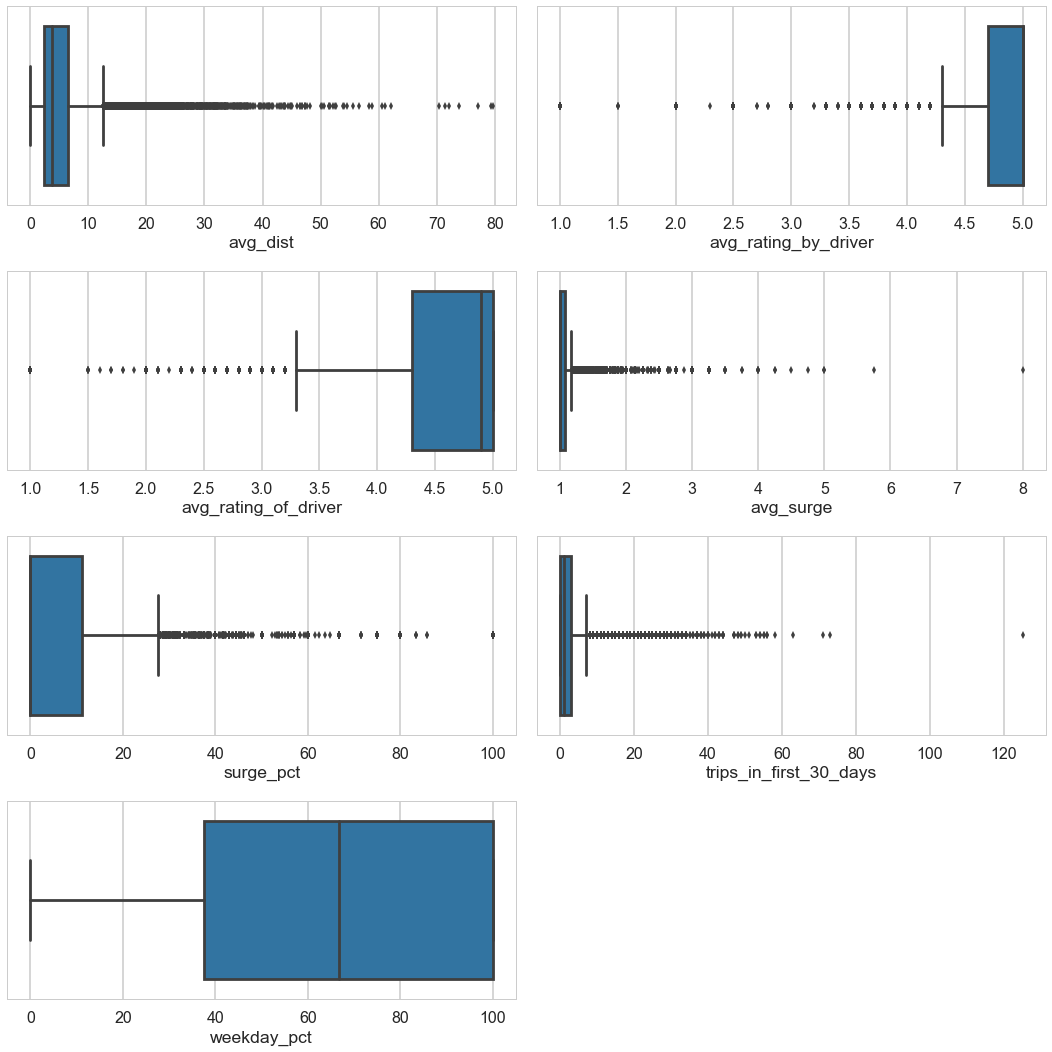

In [95]:
#check outliers

columns = df_filtered.columns
black_list_columns = [u'is_active',           u'city_Astapor',
          u'city_King\'s Landing',        u'city_Winterfell',
                u'phone_Android', 'phone_iPhone', 'ultimate_black_user',
                     'last_trip_date', 'signup_date', 'city', 'phone']
columns = [i for i in columns if i not in black_list_columns]

num_columns = len([i for i in columns if i not in black_list_columns])+1
fig, axes = plt.subplots((num_columns)/2, 2, figsize=(15,15))

for i in range(num_columns):
    col_index = i%2
    row_index = i/2
    
    #in case off number, remove last graph
    try:
        column = columns[i]
    except:
        axes[row_index, col_index].remove()
        break

    sns.boxplot(df_filtered[columns[i]], ax=axes[row_index, col_index])
    #axes[row_index, col_index].boxplot(df_filtered[columns[i]])
    #axes[row_index, col_index].set_title(columns[i])
plt.tight_layout()
plt.show()




We attempt to remove some of the outliers in the below cell.  However, it was noticed that removing all data which is the top/bottom 2.5% resulted in a dataframe that is < 1% of the original size.  Hence, only the average distance variable was considered, as removing outliers in other columns had too much of an impact in the original dataframe.

In [96]:
#eliminate outliers

percentiles_to_keep = 0.25

for column in columns:
    if column in ['avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge', 'surge_pct',\
                 'trips_in_first_30_days', 'weekday_pct']:
        continue
    print column
    quantiles = np.percentile(df_filtered[column].values, [percentiles_to_keep, 100-percentiles_to_keep])
    print quantiles
    df_filtered = df_filtered[(df_filtered[column] > quantiles[0]) & (df_filtered[column] < quantiles[1])]
    print df_filtered.count()
    print '------------------'


avg_dist
[  3.00000000e-02   3.59256000e+01]
avg_dist                  41234
avg_rating_by_driver      41234
avg_rating_of_driver      41234
avg_surge                 41234
city                      41234
last_trip_date            41234
phone                     41234
signup_date               41234
surge_pct                 41234
trips_in_first_30_days    41234
ultimate_black_user       41234
weekday_pct               41234
dtype: int64
------------------


From cleaning and EDA, we notice that there are a lot of null entries for avg_rating_of_users and some avg_rating_by_driver.  We filter these out and end up with 41234 rows out of the original 50000, which is roughly 82% of the original dataframe.
In terms of outliers, we noticed some but removing those would have too big of an impact on the dataframe. Hence we will keep it as is and continue with the next steps.<br>

now we want to create a new column to indicate if a driver was active in the preceding 30 days. Since there is no date on when this data was pulled, we will consider the last date in the dataframe to be the pulled date, and anyone who took a trip in the previous 30days will be marked as active. Also, categorical values in the dataframe will be encoded in a one-hot vector approach so correlation can be tested if drivers in certain cities are more likely to be active.

In [97]:
#get latest date
dates = df_filtered['last_trip_date'].values
dates[::-1].sort()
recent_date = dates[0]

# def is_active(date):
#     diff_day = datetime.strptime(recent_date,"%Y-%m-%d") - datetime.strptime(date, "%Y-%m-%d")
#     if diff_day < timedelta(days=30): 
#         return True
#     else:
#         return False

def is_active(value):
    if value > 0:
        return 1
    else:
        return 0
    
    
def make_date(date):
    return datetime.strptime(date, "%Y-%m-%d")

mask = df_filtered['trips_in_first_30_days'].apply(is_active)
df_filtered.loc[:,'is_active'] = mask


df_filtered.loc[:,'last_trip_date'] = df_filtered['last_trip_date'].apply(make_date)
df_filtered.loc[:,'signup_date'] = df_filtered['signup_date'].apply(make_date)


In [98]:
#work on changing categorical values to numerical
categorical_df = df_filtered.select_dtypes(include=['object'])[['city', 'phone']].copy()

df_filtered = pd.get_dummies(df_filtered, columns=['city', 'phone'])
df_filtered.head()


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,last_trip_date,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,is_active,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,3.67,5.0,4.7,1.10,2014-07-01,2014-01-25,15.4,4,True,46.2,1,0,1,0,0,1
1,8.26,5.0,5.0,1.00,2014-07-01,2014-01-29,0.0,0,False,50.0,0,1,0,0,1,0
2,0.77,5.0,4.3,1.00,2014-07-01,2014-01-06,0.0,3,False,100.0,1,1,0,0,0,1
3,2.36,4.9,4.6,1.14,2014-07-01,2014-01-10,20.0,9,True,80.0,1,0,1,0,0,1
4,3.13,4.9,4.4,1.19,2014-07-01,2014-01-27,11.8,14,False,82.4,1,0,0,1,1,0


## time based analysis

In the following cells, we analyze some of the dates and see if we can find any trends.  We first check if there are certain durations when drivers are more likely to leave the program by using histograms.

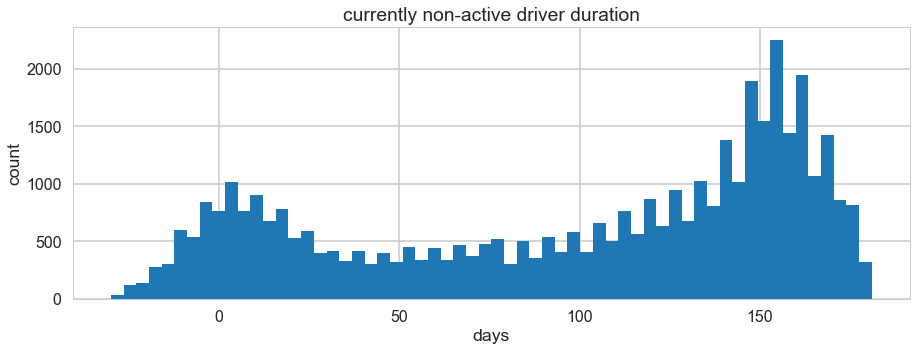

In [99]:
#get the non-active people and check how long they usually last
df_filtered.loc[:, 'length'] = df_filtered['last_trip_date'] - df_filtered['signup_date']
dates_df = df_filtered[['last_trip_date', 'signup_date', 'is_active', 'length']]
#dates_df.loc[:, 'length'] = dates_df['last_trip_date'] - dates_df['signup_date']
dates_df[dates_df['is_active']==False]

durations = [i.days for i in dates_df.length]
plt.figure(figsize=(15,5))
plt.hist(durations, bins=60)
plt.title('currently non-active driver duration')
plt.ylabel('count')
plt.xlabel('days')
#ax = dates_df.hist(column='length')



we notice above that there are some negative values...which indicates that there are some whose signup_date is later then the last trip date.  Let's filter these out also and remake the histogram

In [100]:
df_filtered = df_filtered[(df_filtered['last_trip_date']-df_filtered['signup_date']) > timedelta(days=0)]
df_filtered.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,is_active,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,length
count,37933.000000,37933.000000,37933.000000,37933.000000,37933.000000,37933.000000,37933.000000,37933.000000,37933.000000,37933.000000,37933.000000,37933.000000,37933.000000,37933
mean,5.372992,4.776967,4.601123,1.073885,8.900641,2.618986,61.141199,0.721825,0.325416,0.211109,0.463475,0.290697,0.709303,107 days 16:19:04.164711
std,4.719996,0.398485,0.615380,0.198152,18.259864,4.072973,34.753800,0.448106,0.468536,0.408101,0.498671,0.454090,0.454090,54 days 17:32:18.767827
min,0.040000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1 days 00:00:00
25%,2.430000,4.700000,4.300000,1.000000,0.000000,0.000000,37.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,63 days 00:00:00
50%,3.790000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,126 days 00:00:00
75%,6.460000,5.000000,5.000000,1.070000,11.100000,3.000000,100.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,154 days 00:00:00
max,35.910000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,181 days 00:00:00


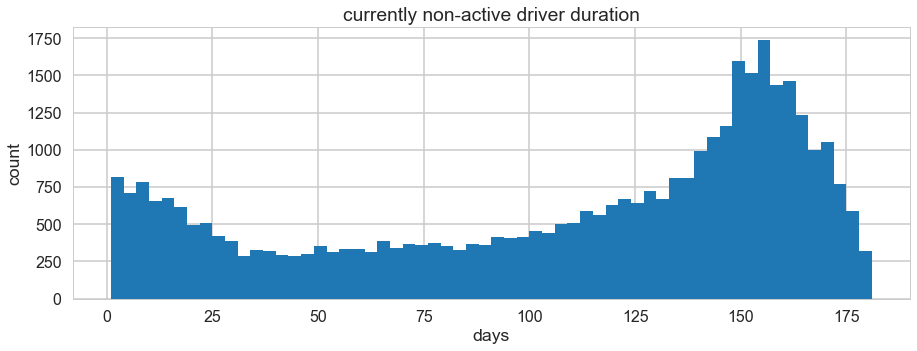

In [101]:
#remake the histogram
dates_df = df_filtered[['last_trip_date', 'signup_date', 'is_active']]
dates_df.loc[:, 'length'] = dates_df['last_trip_date'] - dates_df['signup_date']
dates_df[dates_df['is_active']==False]

durations = [i.days for i in dates_df.length]
plt.figure(figsize=(15,5))
plt.hist(durations, bins=60)
plt.title('currently non-active driver duration')
plt.ylabel('count')
plt.xlabel('days')

Looks better! We see that now there are no one with a negative duration. Here we notice that in the first 25 days, a good number of people stop being active and the rate decreases.  Then it increases around day 100 to a peak at day 150, then again decreases.  this seems like there is some correlation between active users and the duration of their activity.<br>

Below we check correlation between the different dependent variables, and is_active values.  Since is_active was created mainly based off of the trips_in_first_30_days variable, there is high correlation between the two. 

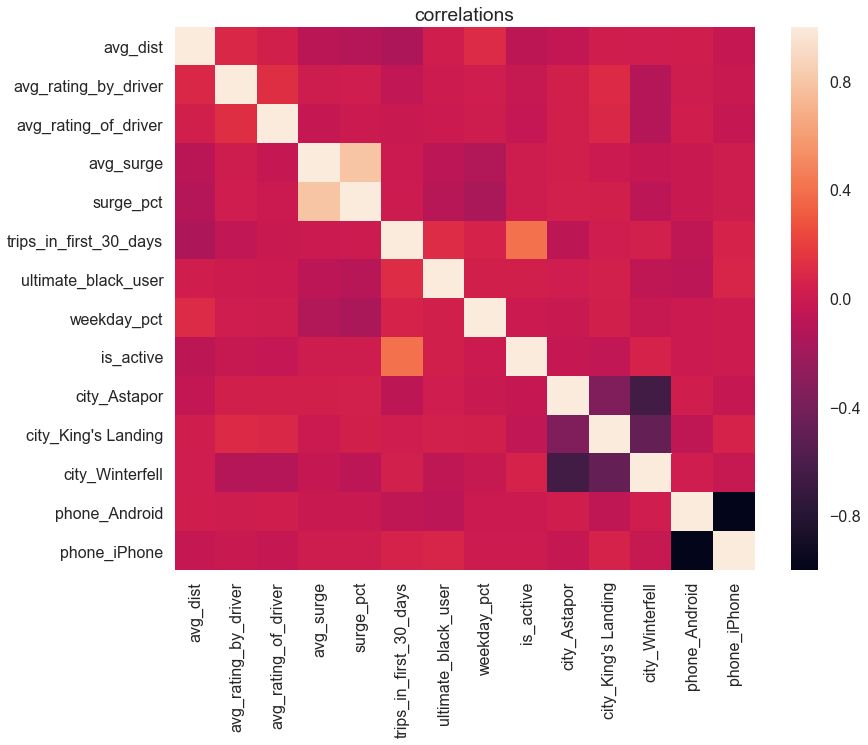

In [102]:
plt.figure(figsize=(13,10))
corr = df_filtered.corr()
sns.heatmap(corr,
           xticklabels=corr.columns.values,
           yticklabels=corr.columns.values)
_ = plt.title('correlations')

In [103]:
#check the raw values of pair wise correlation with is_active
corr['is_active']

avg_dist                 -0.064576
avg_rating_by_driver     -0.021930
avg_rating_of_driver     -0.034795
avg_surge                 0.010622
surge_pct                 0.009093
trips_in_first_30_days    0.399181
ultimate_black_user       0.032273
weekday_pct              -0.005671
is_active                 1.000000
city_Astapor             -0.024261
city_King's Landing      -0.047483
city_Winterfell           0.061654
phone_Android            -0.002017
phone_iPhone              0.002017
Name: is_active, dtype: float64

## Predictive Model Creation

Now that we have a cleaned data and some understanding of it, we continue to create a predictive model to classify whether a user with given features is likely to be an active member or not.  We consider four classifiers: logistic regression, random forest, gradient boosted trees, and non-linear SVM.  <br>

Below, we first create the dependent and independent variables, and ensure to remove the trips_in_the_first_30_days variable because that is directly correlated to is_active. Then we use train_test_split to create a training set that is 70% of the original dataset, and the remaining 30% to be the test set.

In [104]:
#test out logistic regression and see if the data is linearly separable
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split

total_df = df_filtered.drop('length', axis=1).copy()
targets = total_df['is_active']

#drop columns that adds no value to the dataframe
inputs = total_df.drop(['last_trip_date', 'signup_date', 'is_active', u'trips_in_first_30_days',], axis=1)
inputs = inputs[[u'avg_dist', u'avg_rating_by_driver', u'avg_rating_of_driver',
       u'avg_surge', u'surge_pct', 
       u'ultimate_black_user', u'weekday_pct']]

x_train, x_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.3, random_state=42)



In [105]:
inputs.head(3)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.1,15.4,True,46.2
1,8.26,5.0,5.0,1.0,0.0,False,50.0
2,0.77,5.0,4.3,1.0,0.0,False,100.0


In [106]:
#check distribution of classes in training and testing
#to ensure that the two datasets are represented of the whole
print(y_train.values.sum()/float(len(y_train)), y_test.values.sum()/float(len(y_test)))


(0.72236658757955785, 0.72056239015817225)


## Logistic Regression

In [107]:
lr = LogisticRegression()
lr.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [108]:
lr.score(x_test, y_test), lr.score(x_train, y_train)


(0.72021089630931456, 0.72236658757955785)

## Random Forests

In [109]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
print clf.fit(x_train, y_train)
print clf.score(x_test, y_test), clf.score(x_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.658084358524 0.945090950175


In [110]:
#out of curiousity, check the depth of each decision tree of the random forest.
[estimator.tree_.max_depth for estimator in clf.estimators_]

[43, 38, 43, 52, 46, 46, 56, 54, 48, 48]

## Gradient Boosted Trees

In [111]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier()
clf.fit(x_train, y_train)
clf.score(x_test, y_test), clf.score(x_train, y_train)

(0.71906854130052722, 0.72481452189959705)

## SVM

In [112]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(x_train,y_train)
prediction = clf.predict(x_test)
clf.score(x_test, y_test), clf.score(x_train, y_train)

(0.71889279437609843, 0.72797800625164766)

Below, we note the accuracies achieved for each algorithm. It can be seen that logistic regression, Gradient Boosted Classifier (GBC) and SVM achieve very similar accuracies.  Since SVM is using a non-linear kernel but still achieves similar accuracies to logistic regression, it is safe to say that there is some linear relationship between the dependent variables and the independent variable.  Also note that random forests clearly overfit, with a training accuracy of 95% but only 66% for the testing accuracy.  In the next cell, we tune the hyperparameters of random forest to see if we can reduce the ovefitting and get a better prediction accuracy

| Algorithm | training accuracy   | testing accuracy |
|-------------|---------------------|------------------|
|      Logistic Regression      |         72.2       |      72.0       |
|      Random Forest      |       94.6         |       65.9      |
|       Grandient Boosting Classifier     |        72.5       |       71.9    |
|       SVM     |            72.8    |     71.9        |


In [113]:
from sklearn.model_selection import GridSearchCV
forest = RandomForestClassifier()
parameters = {'max_depth':(5, 10, 15), 'criterion':('gini','entropy')}

clf = GridSearchCV(forest, parameters)
clf.fit(x_train, y_train)




GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ('gini', 'entropy'), 'max_depth': (5, 10, 15)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [114]:
clf.score(x_test, y_test), clf.score(x_train, y_train)

(0.72073813708260104, 0.72266787180356273)

Through some basic parameter tuning using grid search, we notice that random forests can behave similarly to the other three classification algorithms by limiting the max_depth of the decision trees.  The original tree with default parameters had depth of 38-56 which was most likely the cause of overfitting.  

Below we check the coefficients of logistic regressions as it is the most informative to the business and see what insights it can bring.  The coefficients can tell us which independent variables are highly correlated to the output.

In [115]:
col_coefficients = zip(lr.coef_[0], inputs.columns)
col_coefficients.sort()
col_coefficients

[(-0.10646984977293267, u'avg_rating_of_driver'),
 (-0.060267954827338245, u'avg_rating_by_driver'),
 (-0.027995258766794637, u'avg_dist'),
 (-0.0001672666625793428, u'weekday_pct'),
 (0.00055104113157856754, u'surge_pct'),
 (0.067518005900829306, u'avg_surge'),
 (0.16793999220906439, u'ultimate_black_user')]

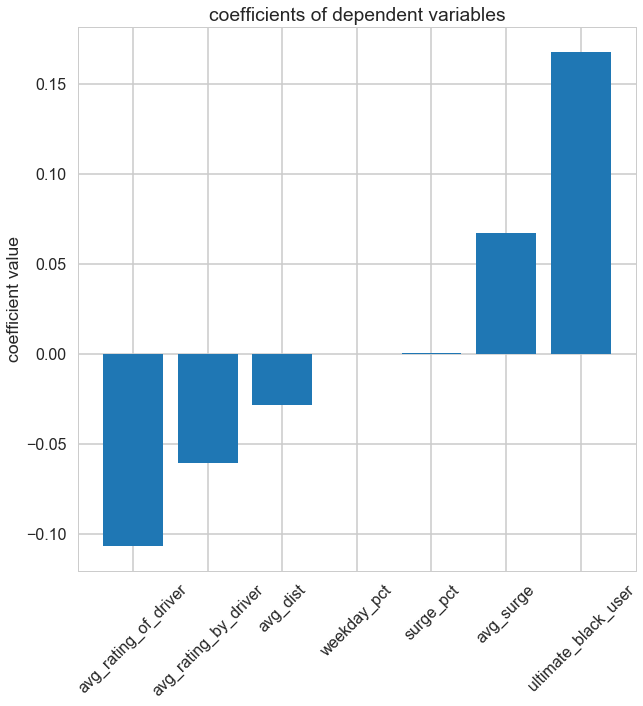

In [116]:
plt.figure(figsize=(10,10))
values = [i[0] for i in col_coefficients]
col_names = [i[1] for i in col_coefficients]
x_s = [i for i in range(len(col_names))]
plt.bar(x_s, values)
plt.xticks(x_s, col_names, rotation=45)
plt.title('coefficients of dependent variables')
plt.ylabel('coefficient value')
_ = plt.show()

From the above it can be seen that there is stronger evidence that users with a higher avg_surge and ultimate_black_users tend to have higher likelihood of being an active user.  Ultimate can build new plans or programs around increasing surge and ultimate black  opportunities which could increase rider retention in the future months. 

In [117]:
#buffer